# Caverns with constraints

In [1]:
import os
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from src import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

CRS = 23029

## Halite data

In [3]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

In [4]:
ds, extent = fns.read_dat_file(DATA_DIR, CRS)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Zones of interest

### With max depth

In [6]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
zones, _ = fns.zones_of_interest(
    ds, extent, CRS,
    {"min_thickness": 300, "min_depth": 1000, "max_depth": 1500},
    display_map=False
)

### Without max depth

In [7]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
zones_, _ = fns.zones_of_interest(
    ds, extent, CRS, {"min_thickness": 300, "min_depth": 1000},
    display_map=False
)

## Constraints

### Exploration wells

In [8]:
DATA_DIR = os.path.join(
    "data", "exploration-wells-irish-offshore",
    "Exploration_Wells_Irish_Offshore.shapezip.zip"
)

wells = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [9]:
wells = wells[wells["AREA"].str.contains("Kish")].to_crs(CRS)

# 500 m buffer - suggested in draft OREDP II p. 108
wells_b = gpd.GeoDataFrame(geometry=wells.buffer(500))

### Wind farms

In [10]:
DATA_DIR = os.path.join(
    "data", "wind-farms-foreshore-process", "wind-farms-foreshore-process.zip"
)

wind_farms = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [11]:
# wind farms near Kish Basin
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = wind_farms.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index().sort_values("Name")

### Dublin Bay Biosphere

In [12]:
DATA_DIR = os.path.join(
    "data", "heritage", "unesco-global-geoparks-and-biospheres.zip"
)

biospheres = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [13]:
biospheres = biospheres[biospheres["Name"].str.contains("Dublin")].to_crs(CRS)

# 5 km buffer - suggested in draft OREDP II p. 58
biospheres_b = gpd.GeoDataFrame(geometry=biospheres.buffer(5000))

### Frequent shipping routes

In [14]:
DATA_DIR = os.path.join(
    "data", "shipping", "shipping_frequently_used_routes.zip"
)

shipping = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [15]:
shipping = shipping.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index()

# routes near Kish Basin
# 1NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping_b = gpd.GeoDataFrame(geometry=shipping.buffer(1852))

## Calculate

In [18]:
def generate_caverns_with_constraints(zones_gdf, diameter, separation):
    """
    Add constraints to cavern configuration
    """

    print("Without constraints...")
    cavern_df = fns.generate_caverns_hexagonal_grid(
        extent, CRS, zones_gdf, diameter, separation
    )

    print("-" * 60)
    print("Exclude exploration wells...")
    cavern_df = cavern_df.overlay(wells_b, how="difference")
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude wind farms...")
    cavern_df = cavern_df.overlay(wind_farms, how="difference")
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude biosphere...")
    cavern_df = cavern_df.overlay(biospheres_b, how="difference")
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude frequent shipping routes...")
    cavern_df = cavern_df.overlay(shipping_b, how="difference")
    print("Number of potential caverns:", len(cavern_df))

    return cavern_df

### With max depth

In [19]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
caverns = generate_caverns_with_constraints(zones, 85, 330)

Without constraints...
Number of potential caverns: 391
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 391
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 378
------------------------------------------------------------
Exclude biosphere...
Number of potential caverns: 373
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 227


### Without max depth

In [20]:
# numbers used in HYSS calculations
# thickness >= 300 m, 1000 m <= depth <= 1500 m, diameter = 85 m
# separation = 330 m
caverns_ = generate_caverns_with_constraints(zones_, 85, 330)

Without constraints...
Number of potential caverns: 589
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 589
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 576
------------------------------------------------------------
Exclude biosphere...
Number of potential caverns: 526
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 317


## Crop data layers

In [21]:
# land boundary
DATA_DIR = os.path.join(
    "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
)

land = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

land = land.dissolve().to_crs(CRS)

In [22]:
# crop land areas from biosphere
biospheres = biospheres.overlay(land, how="difference")

In [23]:
# create exclusion buffer
buffer = pd.concat([biospheres_b, wells_b, shipping_b]).dissolve()

In [24]:
# crop land areas from buffer
buffer = buffer.overlay(land, how="difference")

In [25]:
# crop constraints from buffer
buffer = buffer.overlay(pd.concat([biospheres, wind_farms]), how="difference")

## Plot

In [26]:
def plot_map(dat_xr, cavern_df, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    var : variable
    stat : statistic (max / min / mean)
    """

    # estimates
    print("Number of potential caverns:", len(cavern_df))
    # print(f"Total volume: {len(cavern_df) * 5e5:.2E} m\N{SUPERSCRIPT THREE}")
    # print(f"Storage capacity: {len(cavern_df) * 105.074 / 1e3:.2f} TWh")

    # initialise figure
    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(CRS))

    # configure colour bar based on variable
    if var == "TopTWT":
        units = "ms"
    else:
        units = "m"
    cbar_label = (f"{dat_xr[var].attrs['long_name']} [{units}]")
    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum Halite {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum Halite {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean Halite {cbar_label}"

    # plot halite data
    plot_data[var].plot.contourf(
        cmap="jet", alpha=.65, robust=True, levels=15,
        cbar_kwargs={"label": cbar_label}
    )

    # configure map limits
    plt.xlim(xmin, xmax)
    # plt.ylim(ymin - 4000, ymax + 4000)
    plt.ylim(ymin, ymax)

    # add constraint layers
    buffer.plot(ax=ax, facecolor="none", edgecolor="slategrey", hatch="///")
    wells.centroid.plot(ax=ax, color="black", marker="x")
    wind_farms.plot(ax=ax, facecolor="none", hatch="///", edgecolor="black")
    biospheres.plot(
        ax=ax, facecolor="none", edgecolor="forestgreen", hatch="///"
    )
    shipping.plot(ax=ax, color="deeppink", linewidth=3)

    # add caverns
    cavern_df.centroid.plot(
        ax=ax, markersize=7, color="black", edgecolor="none"
    )
    # cavern_df.plot(ax=ax, edgecolor="none", facecolor="black")

    # configure legend entries
    legend_handles = [
        Line2D(
            [0], [0], marker=".", markersize=7, markeredgecolor="none",
            markerfacecolor="black", linewidth=0, label="Salt cavern"
        )
    ]
    legend_handles.append(
        Line2D(
            [0], [0], marker="x", linewidth=0, markeredgecolor="black",
            label="Exploration well"
        )
    )
    legend_handles.append(
        Line2D([0], [0], color="deeppink", label="Shipping route", linewidth=3)
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", hatch="///", edgecolor="black", label="Wind farm"
        )
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", edgecolor="forestgreen", hatch="///",
            label="Biosphere"
        )
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", hatch="///", edgecolor="slategrey",
            label="Exclusion buffer"
        )
    )

    # add basemap and map elements
    cx.add_basemap(ax, crs=CRS, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"}, alpha=.25,
        color="darkslategrey"
    )
    ax.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

### With max depth

Number of potential caverns: 227


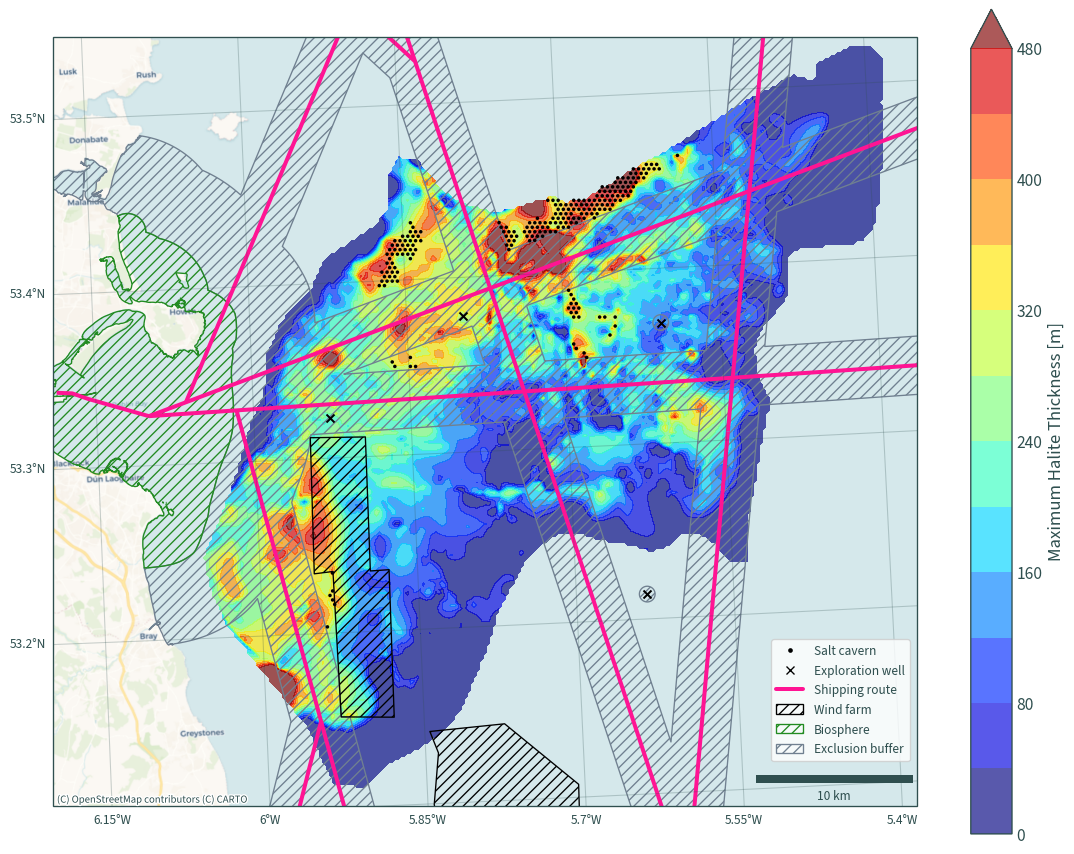

In [35]:
plot_map(ds, caverns, "Thickness", "max")

### Without max depth

Number of potential caverns: 317


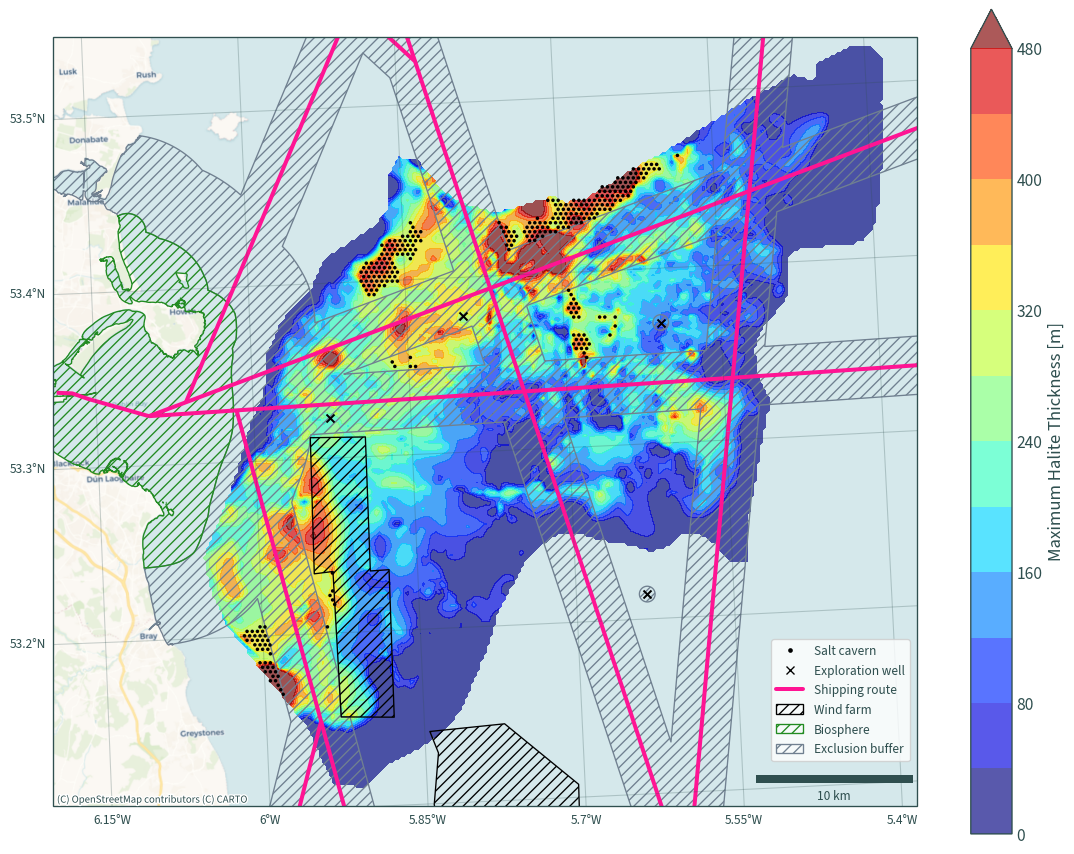

In [27]:
plot_map(ds, caverns_, "Thickness", "max")